### <font color='black'>Topic modeling and text classification</font>

<font color='#404040'>In this notebook, we will perform topic modeling and text classification, relying on *gensim*. The main workflow goes as follows: First, we will create *unigram* and *bigram*. Then, we use unigram and bigram to perform topic modeling separately, and interpret the outcome. Finally, features from the topic models serve as an input for text classification to explain the ratings.</font>


In [283]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso

import mord

from nltk import FreqDist
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

### <font color='black'>Import data</font>

<font color='#404040'>First, we import data cleaned in the previous notebook with relative paths.</font>

In [18]:
# Read data
dat = pd.read_csv('./data/training_data.csv')

### <font color='black'>Topic modeling with unigram</font>

<font color='#404040'>First, we analyze our data with unigram i.e. simple word tokenization. In the previous notebook, we lemmatized our comments and created two columns, namely, *reviews_lem_short* and *reviews_lem*. In this section, we are going to examine and compare their performances.</font>

---

<font color='#404040'>Now, let us first train a LDA topic model using *reviews_lem_short*, consisting of noun and adjective only.</font>

<font color='#404040'>First, we need to tokenize each comment in the column using function *word_tokenize* from *NLTK*. We loop through each comment in *reviews_lem_short*. For those comments with non-missing values, we apply *word_tokenize* and store the tokenized word in a list. At last, we return a collection of lists. The whole process is wrapped in the self-defined function *tokenize_comments*.</font>

<font color='#404040'>In *gensim* framework, we need to return <u>a list of lists</u> to create corpus and dictionary. For example, if we have two sentences <font color='red'>['red apples', 'yellow bananas', np.nan]</font>. The function *tokenize_comments* returns <font color='red'>[['red', 'apples'], ['yellow', 'bananas']]</font>.</font>

In [19]:
# Create unigram tokens for gensim models
def tokenize_comments(comments):
    comments_tokenized = []

    for comment in comments:
        # If the comment is not missing
        if pd.isnull(comment) == False:
            sentence = []
            
            # Loop through each word in tokenized comment, add to the sentence list
            for word in word_tokenize(comment):
                sentence.append(word) 
            
            # Update
            comments_tokenized.append(sentence)

    return comments_tokenized

<font color='#404040'>To perform topic modeling with <font color='blue'>*gensim.models.ldamodel.LdaModel*</font>, we need a <font color='red'>corpus</font> and <font color='red'>dictionary</font>. A <font color='red'>dictionary</font> is a summary for the tokenized comments, attaching unique id and counts to each word in the tokenized comments. Words stored in the dictionary are not arranged in the same order as the input text. So, a <font color='red'>corpus</font> is needed to map the dictionary to the tokenized comments, aligning the data structure in the tokenized comments.</font>

<font color='#404040'>The function as shown below stores the dictionary, corpus and the tokenized comments into a dict object in python. It will call the function *tokenize_comments* defined previously.</font>

<font color='#404040'>Note that <font color='blue'>*filter_extremes*</font> is called in the function with *no_above* = 0.7. It means that we filter out some words which appear frequently. The threshold 0.7 is tuned by trial-and-error. Basically, the jupyter notebook has been rerun for many times, and observing the output from the topic models are observed to determine the threshold.</font>

In [20]:
def get_corpus(dat_uni, lemmatized_reviews):
    # Use cleaned comments to create tokens
    comments_tonkenized = tokenize_comments(dat_uni[lemmatized_reviews])

    # Create dictionary and corpus - (token_id, token_count)
    dictionary = corpora.Dictionary(comments_tonkenized)
    dictionary.filter_extremes(no_above = 0.7) # Avoid common token
    corpus = [dictionary.doc2bow(token) for token in comments_tonkenized]
    
    # Store corpus, dictionary and tokenized comments in a dict() object
    # Because LdaModel and CoherenceModel takes them as arguments
    return {'corpus': corpus, 'dictionary': dictionary, 'comments_tokenized': comments_tonkenized}

<font color='#404040'>Since everything is written in terms of function, we can apply the function to each university.</font>

In [21]:
# Create unigram / tokenization for each university - With noun and adjective only
unigram_oxford = get_corpus(dat[dat['University'] == 'oxford'], 'reviews_lem_short')
unigram_edinburgh = get_corpus(dat[dat['University'] == 'edinburgh'], 'reviews_lem_short')
unigram_warwick = get_corpus(dat[dat['University'] == 'warwick'], 'reviews_lem_short')

<font color='#404040'>In *gensim* framework, the model produces different results when we recall the function. Hence, we need to specify the *seed* to ensure *reproducibility*, which is important in data science projects.</font>

<font color='#404040'>There are many hyperparameters in <font color='blue'>*gensim.models.ldamodel.LdaModel*</font>. For this analysis,  we should focus on the most important hyperparameters, namely, <font color='purple'>*iterations*</font>. It is because <font color='purple'>*iterations*</font> will directly affect the convergence of the LDA models. When a LDA model does not converge, it is *undertrained* which does not detect the hidden text patterns satisfactorily. This parameter should be directly related to the document size. In other words, if the document has more comments, we should use more <font color='purple'>*iterations*</font>. For our dataset, Warwick and Edinburgh have more than 1000 comments whereas Oxford has less than 400. So, we use more <font color='purple'>*iterations*</font> for the former datasets.</font>

In [22]:
# Number of comments per each university
dat['University'].value_counts()

warwick      1067
edinburgh    1054
oxford        360
Name: University, dtype: int64

In [23]:
# Different seeds and iterations for each university
# Seed is needed because the LDA model changes the results when we rerun the script
unigram_oxford['SEED'], unigram_oxford['iterations'] = 20210611, 800
unigram_edinburgh['SEED'], unigram_edinburgh['iterations'] = 20210610, 1500
unigram_warwick['SEED'], unigram_warwick['iterations'] = 20210530, 1000

<font color='#404040'>We define the following *model_building* function for <font color='red'>grid searching</font>. For each university, we fit LDA models with different number of topics, say from 1 to 15 (which is a reasonable range for small size document). By using <font color='blue'>*CoherenceModel*</font>, we can evaluate the coherence scores corresponding to a LDA model. Then, we output a list of coherence scores for each university.</font>

<font color='#404040'>Without going into deep mathematical details, <font color='red'>coherence score</font> measures <u>the cooccurrence of words in the topic within a fixed size slide window in the document</u>. So, a higher coherence score means a better performance in topic extraction because it is associated with higher degree of cooccurrences and so the topic describes the document better. There are several methods to estimate it, for example, *c_v* which uses cosine similarity.</font>

<font color='#404040'>There are other measures e.g. <font color='red'>log-likliehood</font> or <font color='red'>perplexity</font> but coherence score is commonly used in text mining and has a nice interpretation. As only *gensim* offers an easy interface to calculate the coherence scores, we use *gensim* instead of *scikit-learn* for his project.</font>

In [24]:
# Train LDA models, and assess the performance using coherence scores
def model_building(unigram_oxford, unigram_edinburgh, unigram_warwick):
    unigram_results = []

    # Loop through each unversity
    for unigram in [unigram_oxford, unigram_edinburgh, unigram_warwick]:
        # Assume there are at most 15 topics, a reasonable upper bound for small-to-medium dataset
        coherence_scores = []

        for n_topics in np.arange(1, 15):
            # Instantiate a lda model
            ldamodel = gensim.models.ldamodel.LdaModel(unigram['corpus'], num_topics = n_topics, id2word = unigram['dictionary'], 
                                                       iterations = unigram['iterations'], random_state = unigram['SEED'])

            # Instantiate a coherence model and calculate the coherence scores
            ldamodel_coherence = CoherenceModel(model = ldamodel, texts = unigram['comments_tokenized'], dictionary = unigram['dictionary'], 
                                                coherence ='c_v')

            # Update
            coherence_scores.append(ldamodel_coherence.get_coherence())

        # Update
        unigram_results.append(coherence_scores)
    
    return unigram_results

In [25]:
# Get unigram results
unigram_results = model_building(unigram_oxford, unigram_edinburgh, unigram_warwick)

<font color='#404040'>The code below plots the coherence score for each university versus the number of topics used. We can observe the following</font>

- <font color='#404040'>For *Oxford* university, the coherence score is the highest when the number of topics is 3.</font>

- <font color='#404040'>For *Edinburgh* university, the coherence score is the highest when the number of topics is 9.</font>

- <font color='#404040'>For *Warwick* university, the coherence score is the highest when the number of topics is 4.</font>

Text(0.5, 1.0, 'The performance of LDA model - Oxford')

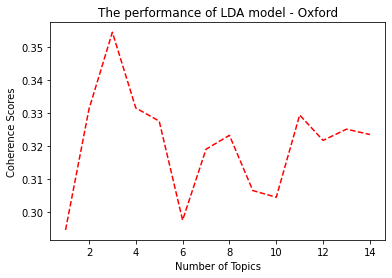

In [26]:
# Highest coherence_scores when number of topics is chosen to be 3
plt.plot(np.arange(1, 15), unigram_results[0], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Oxford')

Text(0.5, 1.0, 'The performance of LDA model - Edinburgh')

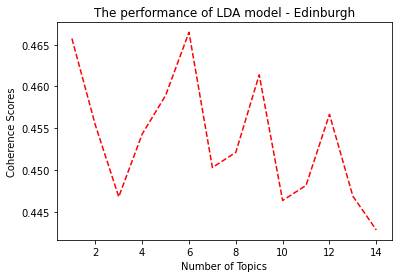

In [27]:
# Highest coherence_scores when number of topics is chosen to be 6
plt.plot(np.arange(1, 15), unigram_results[1], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Edinburgh')

Text(0.5, 1.0, 'The performance of LDA model - Warwick')

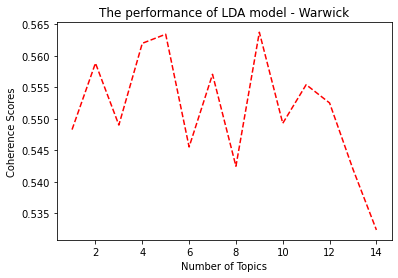

In [28]:
# Highest coherence_scores when number of topics is chosen to be 5
plt.plot(np.arange(1, 15), unigram_results[2], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Warwick')

<font color='#404040'>Based on the coherence score, we pick the best model with the chosen number of topics. The following function reproduces the model and print the top 10 words for each topic.</font>

In [29]:
def train_chosen_models(unigram, num_topics):
    # Train chosen models
    ldamodel= gensim.models.ldamodel.LdaModel(unigram['corpus'], num_topics = num_topics, id2word = unigram['dictionary'], 
                                              iterations = unigram['iterations'], random_state = unigram['SEED'])
    # Print out the model
    topics = ldamodel.print_topics(num_words = 10)
    for topic in topics:
        print(topic)
    
    # Return model
    return ldamodel

<font color='#404040'>Apply the function *train_chosen_models* for each university and examine the output, and we can conclude the followings:</font>

<font color='#404040'>For **Oxford**, </font>

- <font color='#404040'>The first topic relates **positive** adjectives to *student*, *life*, *year*, *course*. Students think that school life, academic year, course works and other students are good and excellent.</font>

- <font color='#404040'>The second topic relates **positive** adjectives to *support*, *library*, *career*, *facility* and *accommodation* but we also find the word *expensive*. Students think that *support*, *library*, *career*, *facility* and *accommodation* are good but expensive. </font>

- <font color='#404040'>The third topic relates **positive** adjectives to *colledge*, *facility*, *support*, *career*, *society* and *service*. It is similar to the first topic.</font>

<font color='#404040'>For **Edinburgh**, </font>

- <font color='#404040'>The first, second and third topics relate **positive** to *city*, *society*, *course*, *support* and *student*. Students find Edinburgh university is good in terms of these aspects. Moreover, students also like the city Edinburgh.</font>

- <font color='#404040'>The fourth topic concerns *student*, *course*, *tutor*, *helpful*, *people*, *many*. Students find teaching staffs are helpful during their studies, and people in the university are good.</font>

- <font color='#404040'>The fifth and sixth topics are similar to the first 3 topics but adding *support* and *facility*. </font>

<font color='#404040'>For **Warwick**, </font>

- <font color='#404040'>The first topic concerns *campus*, *society*, *facility*, *sport*, *club* with adjectives *good*, *great*, *expensive*. Students find Warwick has good campus, society, facility, sport and club but expensive.</font>

- <font color='#404040'>The second topic has the **positive** adjectives with *people*, *student*, *course*, *campus* and *year*.</font>

- <font color='#404040'>The third topic has the **positive** adjectives with *support*, *campus*, *city* and *course*. It is similar to the first topic but students also find the city Warwick and support good.</font>

- <font color='#404040'>The fourth topic has the **positive** adjectives with *career*, *facility*, *society*, *campus* and *student*. Students also think career, facility and society are good in Warwick.</font>

- <font color='#404040'>The fifth topic is similar to the previous topics but include *tutor*.</font>

In [31]:
topic_model_oxford = train_chosen_models(unigram_oxford, 3)
print('-'*30)
topic_model_edinburgh = train_chosen_models(unigram_edinburgh, 6)
print('-'*30)
topic_model_warwick = train_chosen_models(unigram_warwick, 5)

(0, '0.053*"good" + 0.038*"lot" + 0.035*"course" + 0.030*"student" + 0.023*"great" + 0.020*"life" + 0.020*"year" + 0.020*"excellent" + 0.019*"city" + 0.019*"much"')
(1, '0.095*"good" + 0.043*"lot" + 0.028*"college" + 0.024*"support" + 0.023*"great" + 0.021*"accommodation" + 0.020*"expensive" + 0.019*"facility" + 0.017*"library" + 0.016*"career"')
(2, '0.066*"good" + 0.047*"great" + 0.042*"college" + 0.029*"facility" + 0.024*"support" + 0.021*"career" + 0.020*"student" + 0.018*"oxford" + 0.017*"society" + 0.016*"service"')
------------------------------
(0, '0.086*"good" + 0.029*"great" + 0.022*"lot" + 0.021*"society" + 0.020*"uni" + 0.019*"edinburgh" + 0.016*"course" + 0.016*"university" + 0.015*"year" + 0.015*"city"')
(1, '0.047*"lot" + 0.042*"good" + 0.036*"great" + 0.030*"university" + 0.022*"course" + 0.021*"student" + 0.020*"uni" + 0.018*"city" + 0.017*"support" + 0.012*"many"')
(2, '0.038*"student" + 0.027*"edinburgh" + 0.023*"city" + 0.021*"course" + 0.021*"nice" + 0.021*"lot" +

---
<font color='#404040'>Now, we repeat the same analysis using *reviews_lem*, consisting of noun, adjective, verb and adverb.</font>

In [32]:
# Create unigram / tokenization for each university - With all part of speeches
unigram_2_oxford = get_corpus(dat[dat['University'] == 'oxford'], 'reviews_lem')
unigram_2_edinburgh = get_corpus(dat[dat['University'] == 'edinburgh'], 'reviews_lem')
unigram_2_warwick = get_corpus(dat[dat['University'] == 'warwick'], 'reviews_lem')

<font color='#404040'>As we have more words in each comment, we increase <font color='purple'>*iterations*</font> as well to ensure convergence.</font>

In [33]:
# Different seeds and iterations for each university
unigram_2_oxford['SEED'], unigram_2_oxford['iterations'] = 20210611, 1000
unigram_2_edinburgh['SEED'], unigram_2_edinburgh['iterations'] = 20210604, 2000
unigram_2_warwick['SEED'], unigram_2_warwick['iterations'] = 20210526, 1500

<font color='#404040'>Same as before, we use coherence scores to validate the topic models.</font>

In [34]:
# Get unigram results
unigram_2_results = model_building(unigram_2_oxford, unigram_2_edinburgh, unigram_2_warwick)

<font color='#404040'>The code below plots the coherence score for each university versus the number of topics used. We can observe the following</font>

- <font color='#404040'>For *Oxford* university, the coherence score is the highest when the number of topics is 4.</font>

- <font color='#404040'>For *Edinburgh* university, the coherence score is the highest when the number of topics is 4.</font>

- <font color='#404040'>For *Warwick* university, the coherence score is the highest when the number of topics is 3.</font>

Text(0.5, 1.0, 'The performance of LDA model - Oxford')

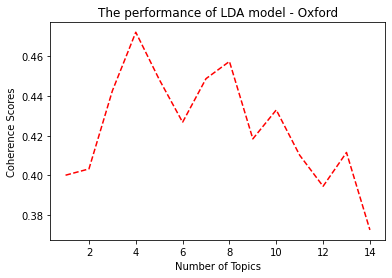

In [35]:
# Highest coherence_scores when number of topics is chosen to be 4
plt.plot(np.arange(1, 15), unigram_2_results[0], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Oxford')

Text(0.5, 1.0, 'The performance of LDA model - Edinburgh')

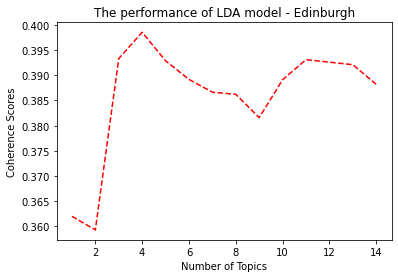

In [36]:
# Highest coherence_scores when number of topics is chosen to be 4
plt.plot(np.arange(1, 15), unigram_2_results[1], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Edinburgh')

Text(0.5, 1.0, 'The performance of LDA model - Warwick')

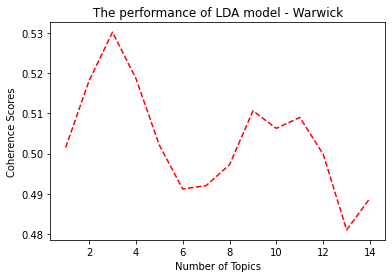

In [37]:
# Highest coherence_scores when number of topics is chosen to be 4
plt.plot(np.arange(1, 15), unigram_2_results[2], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Warwick')

<font color='#404040'>Compared to previous analysis with noun and adjective only, we do not observe new noun or adjective for this analysis. There are some adverbs and verbs e.g. *really*, *n't* and *go* which are hard to interpret. In short, <u>for unigram</u>, the LDA models with noun and adjective only are actually more interpretable.</font>

In [38]:
topic_model_oxford = train_chosen_models(unigram_2_oxford, 4)
print('-'*30)
topic_model_edinburgh = train_chosen_models(unigram_2_edinburgh, 4)
print('-'*30)
topic_model_warwick = train_chosen_models(unigram_2_warwick, 3)

(0, '0.041*"great" + 0.038*"good" + 0.033*"student" + 0.022*"course" + 0.021*"lot" + 0.017*"college" + 0.016*"really" + 0.016*"oxford" + 0.014*"n\'t" + 0.013*"union"')
(1, '0.049*"good" + 0.026*"college" + 0.022*"n\'t" + 0.021*"lot" + 0.020*"great" + 0.016*"really" + 0.015*"career" + 0.014*"facility" + 0.012*"city" + 0.012*"oxford"')
(2, '0.052*"good" + 0.026*"n\'t" + 0.023*"accommodation" + 0.022*"course" + 0.021*"really" + 0.020*"college" + 0.019*"lot" + 0.016*"go" + 0.016*"much" + 0.014*"great"')
(3, '0.071*"good" + 0.026*"support" + 0.026*"really" + 0.025*"lot" + 0.023*"college" + 0.023*"much" + 0.018*"career" + 0.017*"n\'t" + 0.017*"facility" + 0.014*"academic"')
------------------------------
(0, '0.045*"good" + 0.023*"great" + 0.019*"lot" + 0.017*"really" + 0.014*"student" + 0.014*"n\'t" + 0.013*"university" + 0.013*"year" + 0.012*"time" + 0.011*"support"')
(1, '0.051*"good" + 0.030*"great" + 0.019*"university" + 0.017*"n\'t" + 0.016*"student" + 0.015*"edinburgh" + 0.013*"uni" +

### <font color='black'>Topic modeling with bigram</font>

<font color='#404040'>Nonetheless, we observe the weakness with *unigram* which does not incorporate phrases and we find that the LDA model with unigram can contain the same words in different topics. To overcome such problems, we propose the use of *bigram*. A <font color='red'>bigram</font> is a set of tokenized phrases with 2 words.</font>

<font color='#404040'>The function as shown below used <font color='red'>ngram(, 2)</font> from NLTK to create bigram from the comments. Note that *gensim* phraser can also create bigram but [it relies on external dictionary to detect common phrases](https://radimrehurek.com/gensim/models/phrases.html). In other words, if a pair of words is not frequently found in the external reference, *gensim* is not able to detect it. So, the *ngrams* function from NLTK is a better choice because it extracts every pair of words from the text.</font>

In [65]:
# Create bigram tokens for gensim models
def tokenize_bigram_comments(comments):
    comments_tokenized = []

    for comment in comments:
        # If the comment is not missing
        if pd.isnull(comment) == False:
            sentence = []
            
            # Create a bigram using ngrams(words, 2) from NLTK
            # Join every pair of words using an underscore which gives us phrases 
            bigram_collection = ['_'.join(w) for w in ngrams(word_tokenize(comment), 2)]
            
            # Loop through each phrases in bigram, add to the sentence list
            for word in bigram_collection:
                sentence.append(word) 
            
            # Update
            comments_tokenized.append(sentence)

    return comments_tokenized

<font color='#404040'>The function below is exactly the same as before. Note that we have a higher value for the threshold in <font color='blue'>*filter_extremes*</font> because bigram leads to a sparser term-frequency matrix.</font>

In [127]:
def get_bigram_corpus(dat_uni, lemmatized_reviews):
    # Use cleaned comments to create tokens
    comments_tonkenized = tokenize_bigram_comments(dat_uni[lemmatized_reviews])

    # Create dictionary and corpus - (token_id, token_count)
    dictionary = corpora.Dictionary(comments_tonkenized)
    dictionary.filter_extremes(no_above = 0.8) # Avoid common token
    corpus = [dictionary.doc2bow(token) for token in comments_tonkenized]
    
    # Store corpus, dictionary and tokenized comments in a dict() object
    # Because LdaModel and CoherenceModel takes them as arguments
    return {'corpus': corpus, 'dictionary': dictionary, 'comments_tokenized': comments_tonkenized}

<font color='#404040'>Apply the function to create bigram-based corpus for each dictionary.</font>

In [128]:
# Create bigram for each university - With noun and adjective only
bigram_oxford = get_bigram_corpus(dat[dat['University'] == 'oxford'], 'reviews_lem')
bigram_edinburgh = get_bigram_corpus(dat[dat['University'] == 'edinburgh'], 'reviews_lem')
bigram_warwick = get_bigram_corpus(dat[dat['University'] == 'warwick'], 'reviews_lem')

<font color='#404040'>Setting seeds and iterations.</font>

In [150]:
# Different seeds and iterations for each university
# Seed is needed because the LDA model changes the results when we rerun the script
bigram_oxford['SEED'], bigram_oxford['iterations'] = 20210608, 1500
bigram_edinburgh['SEED'], bigram_edinburgh['iterations'] = 20210610, 2000
bigram_warwick['SEED'], bigram_warwick['iterations'] = 20210610, 1500

In [151]:
# Get unigram results
bigram_results = model_building(bigram_oxford, bigram_edinburgh, bigram_warwick)

Text(0.5, 1.0, 'The performance of LDA model - Oxford')

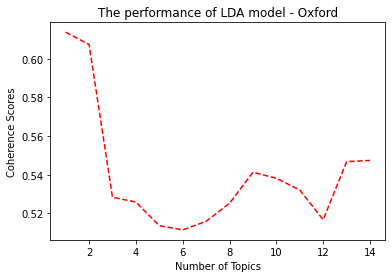

In [152]:
# Highest coherence_scores when number of topics is chosen to be 2
plt.plot(np.arange(1, 15), bigram_results[0], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Oxford')

Text(0.5, 1.0, 'The performance of LDA model - Edinburgh')

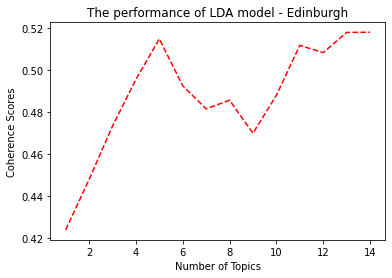

In [153]:
# Highest coherence_scores when number of topics is chosen to be 4
plt.plot(np.arange(1, 15), bigram_results[1], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Edinburgh')

Text(0.5, 1.0, 'The performance of LDA model - Warwick')

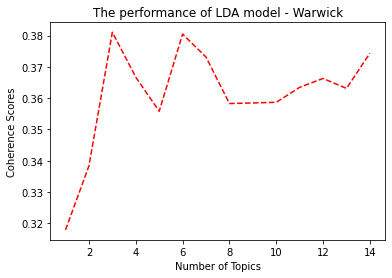

In [154]:
# Highest coherence_scores when number of topics is chosen to be 6
plt.plot(np.arange(1, 15), bigram_results[2], 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model - Warwick')

<font color='#404040'>Apply the function *train_chosen_models* for each university and examine the output, and we can conclude the followings:</font>

<font color='#404040'>For **Oxford**, </font>

- <font color='#404040'>The first topic is related to overall aspects of the university *job_prospect*, *student_union*, *career_fair*, *career_service*, *sport_facility* and *mental_health*. We can see there are both **positive** and **negative** comments e.g. *really_good*, *n't_really*, *n't_know* and *really_enjoy*.</font>

- <font color='#404040'>The second topic is related to *student_union*, *club_society*, *city_life*, *job_prospect*, *support_good*, *good_accommodation* and *academic_support*. Students think Oxford has a good support and accomodation but the word *n\'t_know* is also included in the topic. </font>

<font color='#404040'>For **Edinburgh**, </font>

- <font color='#404040'>The first topic is related to *pollock_hall*, *career_service*, *personal_tutor*, *first_year* and *club_society*. These words are related to **positive** adjectives</font>

- <font color='#404040'>The second topic is related to *study_space*, *personal_tutor*, *far_away*, *career_service*, *career_department* and *good_career*. Students think Edinburgh university has a strong support in career. For the study, we can see *far_away* and *study_space* in the topic, which may probably reflect the inconvenience in going to the studying facilities.</font>

- <font color='#404040'>The third topic is strongly related to career as well.</font>

- <font color='#404040'>The fourth topic focuses on *career_fair*, *student_support*, *university_experience* and *lot_opportunity*.</font>

- <font color='#404040'>The fourth topic focuses on *first_year*, *mental_health*, *n\'t_much*, *great_city*, *life_great* and *city_life*. It may be talking about some mental health issues in the first year of studies, and how students are enjoying the city life in Edinburgh.</font>

<font color='#404040'>For **Warwick**, </font>

- <font color='#404040'>The first topic concerns *facility_good*, *personal_tutor*, *career_fair*, *job_prospect*, *study_space*, *support_service* and *lot_career*. It is about the overall impresson of Warwick university. Students think facility, personal tutor, career, support and study space are good in Warwick.</font>

- <font color='#404040'>The second topic focuses on the **positive** comments on *club_society*.</font>

- <font color='#404040'>The third topic focuses on the *get_involve*, *job_prospect*, *student_union*, *support_service* and *campus_good*. Not only Warwick is good in these aspects (also mentioned in the first topic), students can get involved in different aspects too.</font>

- <font color='#404040'>The fourth topic is similar to the previous but *leamington_coventry* and *everything_need* is added. They are geographical locations near Warwick. Students may think places near Warwick are convenient and you can find everything needed.</font>

In [155]:
topic_model_oxford = train_chosen_models(bigram_oxford, 2)
print('-'*30)
topic_model_edinburgh = train_chosen_models(bigram_edinburgh, 5)
print('-'*30)
topic_model_warwick = train_chosen_models(bigram_warwick, 4)

(0, '0.057*"job_prospect" + 0.056*"really_good" + 0.051*"student_union" + 0.045*"career_fair" + 0.042*"career_service" + 0.040*"n\'t_really" + 0.036*"mental_health" + 0.032*"n\'t_know" + 0.031*"sport_facility" + 0.031*"really_enjoy"')
(1, '0.053*"good_good" + 0.048*"n\'t_know" + 0.042*"student_union" + 0.040*"club_society" + 0.038*"city_life" + 0.035*"job_prospect" + 0.035*"support_good" + 0.026*"good_accommodation" + 0.025*"academic_support" + 0.025*"n\'t_much"')
------------------------------
(0, '0.018*"university_edinburgh" + 0.015*"good_good" + 0.014*"first_year" + 0.014*"student_union" + 0.014*"n\'t_know" + 0.012*"club_society" + 0.012*"personal_tutor" + 0.011*"pretty_good" + 0.011*"career_service" + 0.010*"pollock_hall"')
(1, '0.019*"study_space" + 0.017*"personal_tutor" + 0.014*"career_service" + 0.013*"far_away" + 0.012*"really_enjoy" + 0.011*"great_place" + 0.011*"career_department" + 0.011*"good_career" + 0.010*"really_good" + 0.010*"club_society"')
(2, '0.025*"really_good" 

<font color='#404040'>A short comparison between the results from *unigram* and *bigram*: </font>

- <font color='#404040'>The results from both *unigram* and *bigram* are consistent.</font>

- <font color='#404040'>The results from *bigram* are more detailed and precise. The comments from students can be read and understood easily. However, the results from *unigram* only consists of single words, which are harder to interpret the topic. Those keywords in *unigram* also appear in *bigram*.</font>

- <font color='#404040'>By comparing both analysis, we find that *bigram* gives a better and more interpretable results. For the purpose of exploratory analysis, we recommend the use of *bigram*.</font>

---

<font color='#404040'>Some conclusions regarding topic modeling: </font>

- <font color='#404040'>For the first topic, they are similar across different universities. Student leave positive reviews in general. Students review the universities based on some common measures, namely, career support, student support and student union.</font>

- <font color='#404040'>Accommodation and sport facilities are mentioned in Oxford but not other universities. Based on the unigram, we *expensive* is also associated with Oxford.</font>

- <font color='#404040'>The topics of Edinburgh have a strong emphasis on the city compared to Oxford and Warwick. </font>

- <font color='#404040'>Mental health are mentioned for Oxford and Edinburgh but not for Warwick.</font>

- <font color='#404040'>Career-related words has been mentioned many times for Edinburgh compared to other universities</font>

- <font color='#404040'>Personal tutor is mentioned in the topics for Edinburgh and Warwick.</font>

- <font color='#404040'>Pollock hall is a keyword in the first topic for Edinburgh.</font>

- <font color='#404040'>Leamington, Coventry are keywords in the fourth topic for Warwick.</font>

- <font color='#404040'>Academic support is keyword in the first topic for Oxford.</font>

---

<font color='#404040'>**Question:** Are the results of topic modeling stable?</font>

<font color='#404040'>We experiment with different seeds. The results for Oxford and Edinburgh are very robust to different seeds but the coherence scores for Warwick can vary a lot (from 3 to 12 topics). We pick the seed with fewer topics which has a similar coherence score.</font>

### <font color='black'>Text classification</font>

<font color='#404040'>From the previous sections of topic modeling, we find that the LDA models do not demonstrate a very clear theme per topic. Hence, we decide to run regression with the bigram directly.</font>

<font color='#404040'>The following function converts the bigram into a frequency matrix.</font>

In [182]:
def get_freq_matrix(bigram):
    # Calculate the frequency of the bigram for each comment
    # Convert the results into a pandas dataframe and fill missing values (missing frequency) with 0
    # because they are bigrams not found in the comment 
    return pd.DataFrame(map(FreqDist, bigram['comments_tokenized'])).fillna(0)

<font color='#404040'>Now, apply the function to extract the frequency matrix for each university.</font>

In [260]:
# Frequency matrix for each university
# Note that the frequency matrix has many columns and quite sparse!
freq_matrix_bigram_oxford = get_freq_matrix(bigram_oxford)
freq_matrix_bigram_edinburgh = get_freq_matrix(bigram_edinburgh)
freq_matrix_bigram_warwick = get_freq_matrix(bigram_warwick)

<font color='#404040'>We should also extract the dependent variables for regression, filtering out the missing values, which is done with the following function.</font>

In [322]:
def get_reponse(dat, uni):
    # Identify the row with missing values in the lemmatized comments
    mask_null_comment = dat[dat['University'] == uni]['reviews_lem'].apply(lambda x: pd.isnull(x))
    
    # Given univesity name, return the dataframe of response / dependent variables for prediction
    # Also reset the indices to align with the frequency matrix during regression
    return dat[(dat['University'] == uni) & (mask_null_comment == False)][['score_OVERALL UNIVERSITY RATING', 
                                          'score_Job Prospects', 
                                          'score_Course and Lecturers', 
                                          'score_Uni Facilities', 
                                          'score_Student Support']].reset_index().drop('index', axis = 1)

<font color='#404040'>Now, apply the function to extract the response / dependent variable for each university.</font>

In [323]:
# Now, we create the dataset 
scores_oxford = get_reponse(dat, 'oxford')
scores_edinburgh = get_reponse(dat, 'edinburgh')
scores_warwick = get_reponse(dat, 'warwick')

<font color='#404040'>We use <font color='blue'>*OrdinalRidge*</font> from <font color='blue'>*mord*</font> because we have rating as our response which is ordinal in nature. The model should be picked to align with the nature of dataset. Since we do not have much observations, we use random splitting instead of k-fold cross-validation to grid search the regularization constant. At last, we calculate the average absolute error as our metric / loss for text classification.</font>

In [324]:
# Grid-search validation
def reg_model(X, y):
    # Handle missing values in the dependent variable
    X, y = X[pd.isnull(y) == False], y[pd.isnull(y) == False]
    
    # Train-test split: use 30% as test data
    # Set seed for reproducible results
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 502)
    
    # A list of regularization constants in Lasso
    param = np.arange(0.01, 2, 0.05)
    
    # Grid search object
    error = list()
    for alpha in param:
        # Fit ordinal logistic model with different regularization constants
        mod_ordinalreg = mord.OrdinalRidge(solver = 'auto', alpha = alpha).fit(X_train, y_train)
        
        # Predict the ranking
        y_pred = mod_ordinalreg.predict(X_test)
        
        # Calculate the error with absolute loss
        error.append(np.mean(np.abs(y_pred - y_test)))
        
    return error

<font color='#404040'>We implement a *for-loop* to loop over all the dependent variables.</font>

In [325]:
# Perform regression with grid search for each scoring metric
# Save the results to results_cv
def auto_regression(X, scores):
    # A dictionary to save the loss
    results_cv = dict()
    
    # Loop over dependent variables (different rating)
    for i, col in enumerate(['overall', 'job_prospect', 'course_lecture', 'facilities', 'support']):
        
        # Call reg_model to perform ordinal logistic regression, Update the dictionary
        results_cv[col] = reg_model(X, scores.iloc[:, i])
    
    return results_cv

<font color='#404040'>Now, we can apply the functions defined above to each university.</font>

In [326]:
# Do grid search for each university
results_cv_oxford = auto_regression(freq_matrix_bigram_oxford, scores_oxford)
results_cv_edinburgh = auto_regression(freq_matrix_bigram_edinburgh, scores_edinburgh)
results_cv_warwick = auto_regression(freq_matrix_bigram_warwick, scores_warwick)

<font color='#404040'>The grid-search results of **Oxford**:</font>

- <font color='#404040'>overall: *alpha* = 0.86, *loss* = 0.527778</font>

- <font color='#404040'>job_prospect: *alpha* = 0.01, *loss* = 0.800000</font>

- <font color='#404040'>*course_lecture*, *facilities* and *support* are not sensitive to *alpha*</font>

In [327]:
# Grid search results for Oxford
df_results = pd.DataFrame(results_cv_oxford)
df_results['alpha'] = np.arange(0.01, 2, 0.05)
df_results

,overall,job_prospect,course_lecture,facilities,support,alpha
0,0.537037,0.800000,0.518519,0.638889,0.711538,0.01
1,0.537037,0.809524,0.518519,0.638889,0.711538,0.06
2,0.537037,0.809524,0.509259,0.638889,0.701923,0.11
3,0.537037,0.809524,0.509259,0.638889,0.701923,0.16
4,0.537037,0.809524,0.509259,0.638889,0.701923,0.21
5,0.537037,0.809524,0.509259,0.638889,0.692308,0.26
6,0.537037,0.800000,0.509259,0.638889,0.692308,0.31
7,0.537037,0.800000,0.509259,0.638889,0.692308,0.36
8,0.537037,0.819048,0.500000,0.638889,0.692308,0.41
9,0.537037,0.819048,0.500000,0.638889,0.692308,0.46


<font color='#404040'>The grid-search results of **Edinburgh**:</font>

- <font color='#404040'>overall: *alpha* = 1.96, *loss* = 0.533333</font>

- <font color='#404040'>job_prospect: *alpha* = 1.61, *loss* = 0.811258</font>

- <font color='#404040'>support: *alpha* = 0.854610, *loss* = 0.811258</font>

- <font color='#404040'>*course_lecture* and *facilities* are not sensitive to *alpha*</font>

In [328]:
# Grid search results for Edinburgh
df_results = pd.DataFrame(results_cv_edinburgh)
df_results['alpha'] = np.arange(0.01, 2, 0.05)
df_results

,overall,job_prospect,course_lecture,facilities,support,alpha
0,0.673016,0.913907,0.565079,0.720635,0.946809,0.01
1,0.596825,0.900662,0.561905,0.660317,0.943262,0.06
2,0.561905,0.884106,0.561905,0.641270,0.946809,0.11
3,0.555556,0.874172,0.555556,0.631746,0.939716,0.16
4,0.549206,0.867550,0.555556,0.628571,0.929078,0.21
5,0.549206,0.867550,0.552381,0.641270,0.921986,0.26
6,0.555556,0.867550,0.542857,0.647619,0.911348,0.31
7,0.555556,0.857616,0.542857,0.638095,0.900709,0.36
8,0.558730,0.857616,0.542857,0.638095,0.897163,0.41
9,0.555556,0.854305,0.542857,0.628571,0.897163,0.46


<font color='#404040'>The grid-search results of **Warwick**:</font>

- <font color='#404040'>overall: *alpha* = 1.51, *loss* = 0.487421</font>

- <font color='#404040'>job_prospect: *alpha* = 1.71, *loss* = 0.622222</font>

- <font color='#404040'>support: *alpha* = 1.51, *loss* = 0.660099</font>

- <font color='#404040'>*course_lecture* and *facilities* are not sensitive to *alpha*</font>

In [329]:
# Grid search results for Warwick
df_results = pd.DataFrame(results_cv_warwick)
df_results['alpha'] = np.arange(0.01, 2, 0.05)
df_results

,overall,job_prospect,course_lecture,facilities,support,alpha
0,0.512579,0.660317,0.682390,0.666667,0.807882,0.01
1,0.506289,0.653968,0.657233,0.672956,0.773399,0.06
2,0.509434,0.650794,0.654088,0.666667,0.743842,0.11
3,0.509434,0.650794,0.650943,0.666667,0.729064,0.16
4,0.506289,0.653968,0.638365,0.669811,0.729064,0.21
5,0.503145,0.653968,0.632075,0.666667,0.724138,0.26
6,0.500000,0.657143,0.622642,0.660377,0.714286,0.31
7,0.503145,0.653968,0.619497,0.660377,0.704433,0.36
8,0.500000,0.653968,0.619497,0.654088,0.699507,0.41
9,0.500000,0.650794,0.600629,0.650943,0.694581,0.46


<font color='red'>Now, we can recompile for model for each university regarding *overall* rating. We first define to following function calculate the coefficient from the ordinal logistic models.</font>

In [369]:
def recompile(bigram, scores, alpha):
    # Handle missing values in the dependent variable
    X, y = bigram[pd.isnull(scores) == False], scores[pd.isnull(scores) == False]
    
    # Fit the model with all data
    mod_ordinalreg = mord.OrdinalRidge(solver = 'auto', alpha = alpha).fit(X, y)
    
    # Get the coefficient
    output = pd.DataFrame()
    output['words'] = bigram.columns.tolist()
    output['coef_'] = mod_ordinalreg.coef_
    
    # Return
    return output

<font color='#404040'>Now, we sort the output by the magnitude of coefficients for each university.</font>

<font color='#404040'>**Oxford:** Positive coefficients are associated with clean, best university, music, drinking, good diversity, sport. For negative coefficients, most of them are actually *positive* comments. It shows that students give Oxford a good reviews in general. There are negative words, for example, bad job, mathematics, intensive work, stressful and getting master. In topic modeling (previous section), mental health is listed in the first topic. Maybe stressful and intensive coursework are the factors leading to worse reviews from students.</font>

In [370]:
# Oxford
output = recompile(freq_matrix_bigram_oxford, scores_oxford.iloc[:, 0], 1.96)
print(output.sort_values('coef_').head(20)) # Sort by magnitude and take the top 20
print(output.sort_values('coef_').tail(20)) # Sort by magnitude and take the bottom 20

                      words     coef_
1852       interest_intense -0.412712
959         amazing_library -0.412712
1056           well_situate -0.412712
2172                 %_math -0.372756
2170           talk_economy -0.372756
2169             never_talk -0.372756
2171              economy_% -0.372756
1272                bad_job -0.336189
1273                job_lot -0.336189
1268        interesting_lot -0.336189
1267  stressful_interesting -0.336189
1269               lot_fair -0.336189
1274              lot_stuff -0.335226
5027                 .._get -0.324805
5026                funs_.. -0.324805
5025              good_funs -0.324805
5029           master_catch -0.324805
5028             get_master -0.324805
5031            pokemons_go -0.324805
5030         catch_pokemons -0.324805
                   words     coef_
3027     excellent_clean  0.141185
3028     clean_practical  0.141185
3030         value_money  0.141185
1893          love_place  0.143901
1549            lot_work  0

<font color='#404040'>**Edinburgh:** Positive coefficients are associated with gym, Edinburgh university itself (reputation), Pollock hall ( a residence hall), helpful students and expensive. It may be a bit strange to say "expensive" is a factor of higher rating. The negative coefficients are associated with far away from campus, poor accessibility, student counsel, private flat, flat difficulty, poor student, art student and spending time. Some words with positive are included e.g. good_excellent, great accessible. Nonetheless, we can interpret the remaining words. Students find studying in Edinburgh university has diffculty in finding flat (private flat), time consuming and far away from campus. Also, some issues with student counsel, the quality of students and art students.</font>

In [371]:
# Edinburgh
output = recompile(freq_matrix_bigram_edinburgh, scores_edinburgh.iloc[:, 0], 0.86)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                      words     coef_
6148         good_excellent -0.807432
8925        accessible_city -0.787703
8924       great_accessible -0.787703
2832            away_campus -0.706161
8968  portuguese_department -0.673566
7365         good_deaceness -0.673566
5291      disability_access -0.483176
5292            access_poor -0.483176
5293               poor_non -0.483176
5294       existent_student -0.483176
64          student_counsel -0.454210
1686           non_existent -0.450386
2537            art_student -0.448248
1603             send_email -0.448216
1941         flat_difficult -0.438053
1940           private_flat -0.438053
2536                 'm_art -0.432572
1604             email_good -0.419150
565            poor_student -0.410536
2989             spend_time -0.355284
                      words     coef_
1142       university_great  0.290451
1176   excellent_university  0.291245
3448               good_fun  0.307231
6218                fab_gym  0.312755
6998        

<font color='#404040'>**Warwick:** Positive coefficients are associated with master studies, safety, Leamington Spa, high coursework quality. But bad accomodation is also included. Negative coefficients are associated with tutor session, infrequent session, waiting time, expensive much to say, and middle reputation. Although some words e.g. top notch and diversity is included, most of them are negative experience. There is something wrong with the frequency of tutoring session, tuition fee and waiting time in Warwick university. </font>

In [372]:
# Warwick
output = recompile(freq_matrix_bigram_warwick, scores_warwick.iloc[:, 0], 1.51)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                            words     coef_
2179                    top_notch -0.929016
3964                    long_wait -0.598116
6337                     hear_see -0.578361
6336                   never_hear -0.578361
1503                    wait_time -0.540468
7724           session_infrequent -0.501661
7723                tutor_session -0.501661
868                      much_say -0.405968
2002              quite_expensive -0.404314
5413                  alright_job -0.368430
5412              diverse_alright -0.368430
5411   socio-economically_diverse -0.368430
5410     great_socio-economically -0.368430
1795               middle_nowhere -0.311561
1740           understanding_time -0.297356
9508                    've_mixed -0.293461
9509             mixed_experience -0.293461
688                     time_need -0.283684
839                personal_tutor -0.269218
15406           reputation_middle -0.225659
                      words     coef_
4812         good_fantastic  0.254957


<font color='blue'>Now, we can recompile for model for each university regarding *job_prospect* rating.</font>

<font color='#404040'>However, we find that the words do not relate much to *job_prospect*. It may be due to the operation that all comments are concatenated together to ensure sufficient observations.</font>

In [375]:
# Oxford
output = recompile(freq_matrix_bigram_oxford, scores_oxford.iloc[:, 1], 0.01)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                    words     coef_
959       amazing_library -1.207223
1056         well_situate -1.207223
1509           good_sport -0.419746
701         enough_answer -0.413419
700           know_enough -0.394014
4284           go_student -0.344646
4285           union_city -0.344646
4286            good_best -0.344646
4282       never_anything -0.344646
4281           suck_never -0.344646
4280        academia_suck -0.344646
4288         thing_coffee -0.344646
4283          anything_go -0.344646
4287           best_thing -0.326278
944             good_good -0.316849
1795           first_year -0.313604
683            refuse_uac -0.304064
682      sometimes_refuse -0.304064
684         uac_residence -0.304064
681   expensive_sometimes -0.304064
                   words     coef_
815          get_involve  0.287550
1549            lot_work  0.326608
1885        society_good  0.330662
1776  library_phenomenal  0.350424
1777    phenomenal_sport  0.350424
1182   holiday_residence  0.388410

In [376]:
# Edinburgh
output = recompile(freq_matrix_bigram_edinburgh, scores_edinburgh.iloc[:, 1], 1.61)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                   words     coef_
6148      good_excellent -0.908296
8446            look_yet -0.808850
2280            n't_look -0.752478
15322          eusa_need -0.652370
15321           uni_eusa -0.652370
1183           need_good -0.651656
2144     good_experience -0.575996
2536              'm_art -0.554044
1922          never_seat -0.542857
565         poor_student -0.487167
7303     business_school -0.452690
7301     manage_organise -0.436147
7302   organise_business -0.436147
7300     everything_well -0.436147
6973        point_easily -0.434350
6971       hotlines_drop -0.434350
6972          drop_point -0.434350
6974    easily_available -0.434350
6970        lot_hotlines -0.434350
2537         art_student -0.425002
                      words     coef_
6609           amazing_city  0.313249
3431           pollock_hall  0.313615
14552     quality_education  0.324570
2504              good_know  0.328434
1143         great_location  0.328738
1176   excellent_university  0.332333

In [377]:
# Warwick
output = recompile(freq_matrix_bigram_warwick, scores_warwick.iloc[:, 1], 1.71)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                   words     coef_
9508           've_mixed -0.552857
9509    mixed_experience -0.552857
4493        friend_enjoy -0.510468
3628            tbh_sure -0.440446
3627            cool_tbh -0.440446
3626         pretty_cool -0.417043
4813        people_great -0.411989
1688     reasonable_high -0.392447
8021    comfortable_room -0.387860
1743            good_yes -0.370077
6168         good_friend -0.365319
675           quite_good -0.364207
3050        liberty_park -0.359926
6607           uni_fault -0.345260
3045         library_big -0.329069
1704      academic_tutor -0.328663
2340  accommodation_year -0.325779
2414          n't_really -0.324308
1795      middle_nowhere -0.314552
3964           long_wait -0.307469
                  words     coef_
2046        email_event  0.243265
6468        social_side  0.246236
8022  housing_nightmare  0.249162
9789   university_learn  0.256052
274        job_prospect  0.261215
8298   load_opportunity  0.263269
9724       enjoy_master  0.

<font color='orange'>Now, we can recompile for model for each university regarding *support* rating.</font>

<font color='#404040'>Again, we find that for all universities, the words are more related to *overall* rating.</font>

In [379]:
# Oxford
output = recompile(freq_matrix_bigram_oxford, scores_oxford.iloc[:, -1], 1)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                  words     coef_
1852   interest_intense -0.837342
2171          economy_% -0.534937
2170       talk_economy -0.534937
2172             %_math -0.534937
2169         never_talk -0.534937
1271           good_bad -0.495136
1901      lovely_people -0.431427
1900        city_lovely -0.419574
1055  far_accommodation -0.418671
1053      faculty_guide -0.418671
1054          guide_far -0.418671
1899     beautiful_city -0.392258
180        support_good -0.361564
2882    however_subject -0.342468
2880      service_appal -0.342468
2884         great_idea -0.342468
2881      appal_however -0.342468
569         much_coding -0.337342
959     amazing_library -0.337342
3262        music_great -0.337342
                   words     coef_
4315          union_need  0.259494
2824             st_hugh  0.262051
2823              uni_st  0.262051
2825        hugh_college  0.262051
1058             n't_get  0.262647
4290  service_university  0.265158
1516            good_uni  0.277109
1136  

In [380]:
# Edinburgh
output = recompile(freq_matrix_bigram_edinburgh, scores_edinburgh.iloc[:, -1], 0.854610)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                        words     coef_
7710            good_disabled -1.430753
1879         student_activity -0.930083
6225       expensive_cappella -0.929545
6226         cappella_society -0.929545
1880       activity_expensive -0.929255
2832              away_campus -0.897598
7318              great_nacho -0.891556
6288          excellent_nacho -0.891556
15827              decent_uni -0.891556
565              poor_student -0.841511
1844               really_fun -0.794245
4798               brae_house -0.769000
4396          support_overall -0.709648
5272             email_career -0.651179
13271         support_enhance -0.639574
6148           good_excellent -0.631617
6307   department_opportunity -0.621349
1183                need_good -0.619618
2099            overall_great -0.609785
15321                uni_eusa -0.584645
                   words     coef_
8925     accessible_city  0.471697
8924    great_accessible  0.471697
6109        sciennes_run  0.471697
6110           run_c

In [381]:
# Warwick
output = recompile(freq_matrix_bigram_warwick, scores_warwick.iloc[:, -1], 1.51)
print(output.sort_values('coef_').head(20))
print(output.sort_values('coef_').tail(20))

                     words     coef_
1740    understanding_time -0.815904
6337              hear_see -0.801432
6336            never_hear -0.801432
688              time_need -0.765108
4728  difficult_department -0.722322
2179             top_notch -0.705858
1503             wait_time -0.575490
3964             long_wait -0.515834
1900       terrible_enough -0.510531
1901        enough_parking -0.510531
1899  counselling_terrible -0.510531
1902          parking_good -0.510531
1691           career_fair -0.478575
7724    session_infrequent -0.419607
7723         tutor_session -0.419607
4333             go_london -0.366315
6466              like_uni -0.350942
6468           social_side -0.350942
6467            uni_social -0.350942
839         personal_tutor -0.340206
                       words     coef_
3636            little_thing  0.276212
3635        inconvenient_far  0.276212
1837             value_money  0.280639
2399               thing_n't  0.287640
1643              little_bit

### <font color='black'>Conclusion</font>

<font color='#404040'>Here, we would like to conclude the work for this project. First, we scrape the data from the website using BeautifulSoup. Then, we proceed to cleaning the data and find that missing values are problematic, which motivate us to concatenate the comments together. Next, we apply lemmatization and POS tagging to the comment for text cleaning. Finally, we perform topic modeling with unigram and bigram, as well as text classification.</font>

<font color='#404040'>For topic modeling, the results are summarized in the previous sections. For each university, we find the topics and the words/phrases associated with high weighting. We interpret the results in an exploratory manner, and validate the LDA model using coherence scores.</font>

<font color='#404040'>For text classification, we apply ordinal logistic regression with regularization to the bigram and the reviews score because the extracted features from topic models are not very clear. There are some overlapping concepts / words among the topics. For this reason, we proceed with the bigram instead of the topics. For the validation process, we apply train-test split with 70/30 ratio and grid searching the regularization constants. With tuned hyperparameters, we fit the ordinal logistic regression model for different ratings, and interpret the outcome. The coefficients are sort in terms of their magnitude, and the top and bottom 20 are printed for interpretation. However, the results for other rating metrics e.g. *job_prospect*, *course_lecture* and *support*  are no different from *overall*. It may be due to the process of concatenating the comments. As missing values are problematic for these rating categories, it explains why we cannot have meaningful outcome for the rating categories except for *overall*. In this sense, the interpretation of the text classification section should focus on *overall* rating, ignoring other categories. </font>

This project presents a comprehensive workflow and python code from data collection to text mining, and justify different choices of methods. Thank you for reading the jupyter notebooks!